In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_dataset():
    train = pd.read_csv("../data/train.csv")
    test = pd.read_csv("../data/test.csv")
    submission = pd.read_csv("../data/sample_submission.csv")

    train, test = obj2int(train), obj2int(test)
    train, test = float2int(train), float2int(test)
    train, test = int2cont(train), int2cont(test)

    train = train[train["부채_대비_소득_비율"] < 9999].reset_index(drop=True)

    return train, test, submission


def obj2int(df):
    """
    train & test
    """
    df["대출기간"] = df["대출기간"].apply(
        lambda x: int(x[1:3]) // 12
    )  # 근로기간이 years 단위이므로 12로 나누어 단위 통합
    df["근로기간"] = df["근로기간"].replace(
        {
            "1 year": "1 years",
            "10+years": "10+ years",
            "< 1 year": "<1 year",
            "3": "3 years",
        }
    )

    replaced_duration = {}
    replaced_duration["<1 year"] = 1

    for i in range(1, 10):
        replaced_duration[f"{i} years"] = i + 1

    replaced_duration["10+ years"] = 11

    df["근로기간"] = df["근로기간"].replace(replaced_duration)
    df["근로기간"] = df["근로기간"].replace("Unknown", 0)

    return df


def float2int(df):
    df[["연체계좌수"]] = df[["연체계좌수"]].astype(int)

    return df


def int2cont(df):
    df[["대출금액", "연간소득", "총상환원금", "총상환이자"]] = df[
        ["대출금액", "연간소득", "총상환원금", "총상환이자"]
    ].astype(float)

    return df


def get_features(df):
    obj_features = df.dtypes[df.dtypes == object].keys().tolist()
    int_features = df.dtypes[df.dtypes == int].keys().tolist()
    cont_features = df.dtypes[df.dtypes == float].keys().tolist()

    return obj_features, int_features, cont_features


def make_fold_dataset(
    X_train, y_train, n_fold: int = 5
):
    S_kfold = StratifiedKFold(n_splits=n_fold)

    trainset, validset = [], []
    scaled_trainset, scaled_validset = [], []

    for tr_idx, val_idx in S_kfold.split(X_train, y_train):
        X_tr, X_val = X_train.loc[tr_idx], X_train.loc[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        trainset.append((X_tr, y_tr))
        validset.append((X_val, y_val))

        X_tr, X_val = scale_dataset(X_tr, X_val)

        scaled_trainset.append((X_tr, y_tr))
        scaled_validset.append((X_val, y_val))

    return trainset, validset, scaled_trainset, scaled_validset


def scale_dataset(X_train, X_test=None):
    numerical_features = (
        X_train.dtypes[(X_train.dtypes == "int") | (X_train.dtypes == "float")]
        .keys()
        .tolist()
    )

    scaler = RobustScaler() # 5가지 스케일러에 대해 실험 결과 가장 좋은 성능을 보인 스케일러
    scaler.fit(X_train[numerical_features])
    X_train[numerical_features] = scaler.transform(X_train[numerical_features])
    if X_test is not None:
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])

    return X_train, X_test


def make_features(df):
    """
    중요변수들인 ["총상환이자", "총상환원금", "대출기간", "대출금액"] 를 활용한 피처엔지니어링
    """

    df["월별상환총액"] = (df["총상환원금"] + df["총상환이자"]) / df["대출기간"]
    df["월별상환원금"] = (df["총상환원금"]) / df["대출기간"]
    df["월별상환이자"] = (df["총상환이자"]) / df["대출기간"]

    df["대출금액대비상환총액"] = (df["총상환원금"] + df["총상환이자"]) / (df["대출금액"])
    df["대출금액대비상환원금"] = df["총상환원금"] / df["대출금액"]
    df["대출금액대비상환이자"] = df["총상환이자"] / df["대출금액"]

    df["월별대출금액"] = df["대출금액"] / df["대출기간"]

    df["남은대출금액"] = df["대출금액"] - df["총상환원금"]
    df["대출금액대비남은대출금액"] = df["남은대출금액"] / df["대출금액"]

    df["상환총액대비남은대출금액"] = df["남은대출금액"] / (df["총상환원금"] + 1)

    df["총상환원금대비총상환이자비율"] = 100 * (df["총상환이자"] / (df["총상환원금"] + 1))
    df["총상환이자대비총상환원금비율"] = 100 * (df["총상환원금"] / (df["총상환이자"] + 1))

    df["총상환원금대비남은대출금액"] = df["남은대출금액"] / (df["총상환원금"] + 1)
    df["총상환이자대비남은대출금액"] = df["남은대출금액"] / (df["총상환이자"] + 1)

    df["총상환원금대비월별상환총액"] = df["월별상환총액"] / (df["총상환원금"] + 1)
    df["총상환이자대비월별상환총액"] = df["월별상환총액"] / (df["총상환이자"] + 1)

    df["총상환원금대비월별상환원금"] = df["월별상환원금"] / (df["총상환원금"] + 1)
    df["총상환이자대비월별상환원금"] = df["월별상환원금"] / (df["총상환이자"] + 1)

    df["총상환원금대비월별상환이자"] = df["월별상환이자"] / (df["총상환원금"] + 1)
    df["총상환이자대비월별상환이자"] = df["월별상환이자"] / (df["총상환이자"] + 1)

    df["월별총상환원금대비총상환이자비율"] = df["총상환원금대비총상환이자비율"] / df["대출기간"]
    df["월별총상환이자대비총상환원금비율"] = df["총상환이자대비총상환원금비율"] / df["대출기간"]

    return df

In [3]:
train, test, submission = load_dataset()

In [4]:
train = make_features(train)
test = make_features(test)

생성한 변수들 중 변수 선택 기법을 통해 5-fold validation 에서 가장 좋은 성능을 보인 변수는 아래와 같음

- ['총상환이자대비총상환원금비율', '대출기간', '총상환원금대비총상환이자비율', '대출금액대비상환원금', '대출금액대비상환총액']

In [5]:
final_features = ['총상환이자대비총상환원금비율', '대출기간', '총상환원금대비총상환이자비율', '대출금액대비상환원금', '대출금액대비상환총액']

train, test = train[final_features + ["대출등급"]], test[final_features]

In [6]:
train.describe()

,총상환이자대비총상환원금비율,대출기간,총상환원금대비총상환이자비율,대출금액대비상환원금,대출금액대비상환총액
count,9.629300e+04,96293.000000,9.629300e+04,96293.000000,96293.000000
mean,4.829444e+04,3.660796,2.257995e+03,0.047841,0.070408
std,5.438729e+06,0.940718,4.700895e+05,0.047854,0.054308
min,0.000000e+00,3.000000,0.000000e+00,0.000000,0.000000
25%,1.120079e+02,3.000000,2.635087e+01,0.023493,0.032797
50%,2.161321e+02,3.000000,4.256063e+01,0.043673,0.065304
75%,3.335494e+02,5.000000,7.544517e+01,0.069640,0.096486
max,1.200000e+09,5.000000,1.354656e+08,1.000000,1.046424


["총상환이자대비총상환원금비율", "총상환원금대비총상환이자비율"] 두 변수는 이상치가 존재 (스케일이 매우 큼)

In [7]:
outlier_features = ["총상환이자대비총상환원금비율", "총상환원금대비총상환이자비율"]

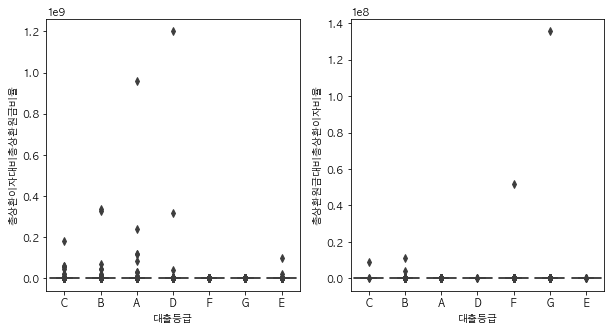

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, feat in enumerate(outlier_features):
    sns.boxplot(data=train, y=feat, x="대출등급", ax=axes[i])

plt.show()

맨 뒤의 두 포인트를 삭제했을 때의 분포 확인

In [9]:
cond1 = train["총상환이자대비총상환원금비율"] > 0.8 * 1e9
cond2 = train["총상환원금대비총상환이자비율"] > 0.4 * 1e8

In [10]:
new_train = train[(~cond1) & (~cond2)].reset_index(drop=True)

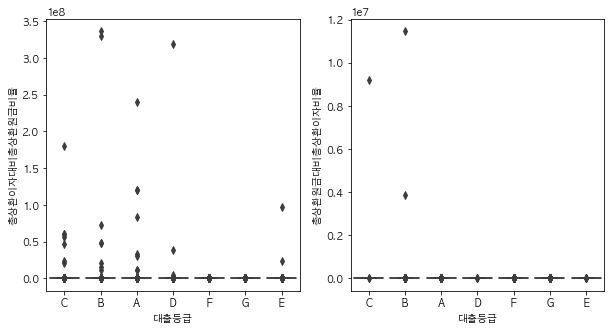

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, feat in enumerate(outlier_features):
    sns.boxplot(data=new_train, y=feat, x="대출등급", ax=axes[i])

plt.show()

제거를 하더라도 스케일이 매우 크므로 러프하게 확인

In [12]:
train["총상환이자대비총상환원금비율"].describe(percentiles=(0.1, 0.25, 0.5, 0.75, 0.9, 0.99)).astype(int)

count         96293
mean          48294
std         5438728
min               0
10%              66
25%             112
50%             216
75%             333
90%             447
99%             690
max      1200000000
Name: 총상환이자대비총상환원금비율, dtype: int64

대부분의 범위가 세자리 수

In [13]:
100 * sum(train["총상환이자대비총상환원금비율"] > 1000) / len(train)

0.5784428774677287

전체데이터의 약 0.57 퍼센트가 세자리수를 넘어감, 따라서 이상치를 1000으로 변환

이 때 전부다 1000 으로 바꿔버리면 증감성을 반영하기 힘드므로 로그변환까지 합산

In [14]:
train.loc[train["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"] = 1000 + np.log(train.loc[train["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"])

test.loc[test["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"] = 1000 + np.log(test.loc[test["총상환이자대비총상환원금비율"] > 1000, "총상환이자대비총상환원금비율"])

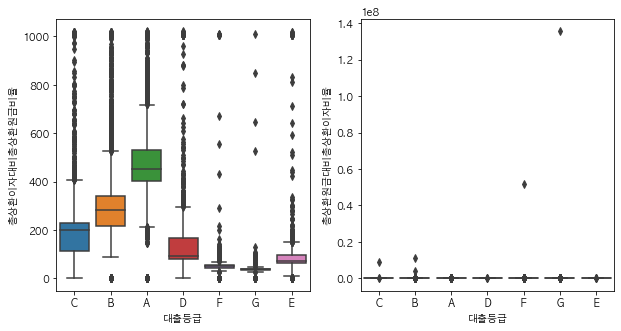

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, feat in enumerate(outlier_features):
    sns.boxplot(data=train, y=feat, x="대출등급", ax=axes[i])

plt.show()

"총상환이자대비총상환원금비율" 의 경우는 어느 정도 나아진 듯함, 다음으로 "총상환원금대비총상환이자비율" 처리 필요

In [16]:
train["총상환원금대비총상환이자비율"].describe(percentiles=(0.1, 0.25, 0.5, 0.75, 0.9, 0.99)).astype(int)

count        96293
mean          2257
std         470089
min              0
10%             17
25%             26
50%             42
75%             75
90%            126
99%            212
max      135465600
Name: 총상환원금대비총상환이자비율, dtype: int64

In [17]:
100 * sum(train["총상환원금대비총상환이자비율"] > 300) / len(train)

0.045693871828689524

In [18]:
train.loc[train["총상환원금대비총상환이자비율"] > 300, "총상환원금대비총상환이자비율"] = 300 + np.log(train.loc[train["총상환원금대비총상환이자비율"] > 300, "총상환원금대비총상환이자비율"])

test.loc[test["총상환원금대비총상환이자비율"] > 300, "총상환원금대비총상환이자비율"] = 300 + np.log(test.loc[test["총상환원금대비총상환이자비율"] > 300, "총상환원금대비총상환이자비율"])

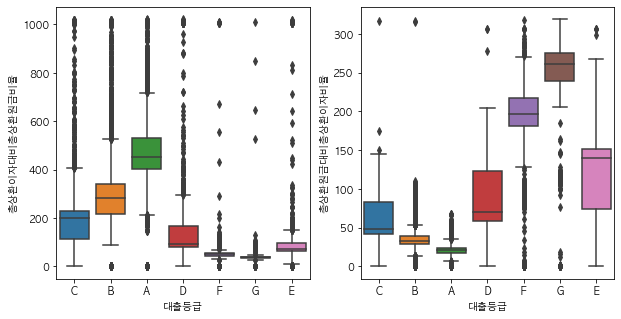

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, feat in enumerate(outlier_features):
    sns.boxplot(data=train, y=feat, x="대출등급", ax=axes[i])

plt.show()

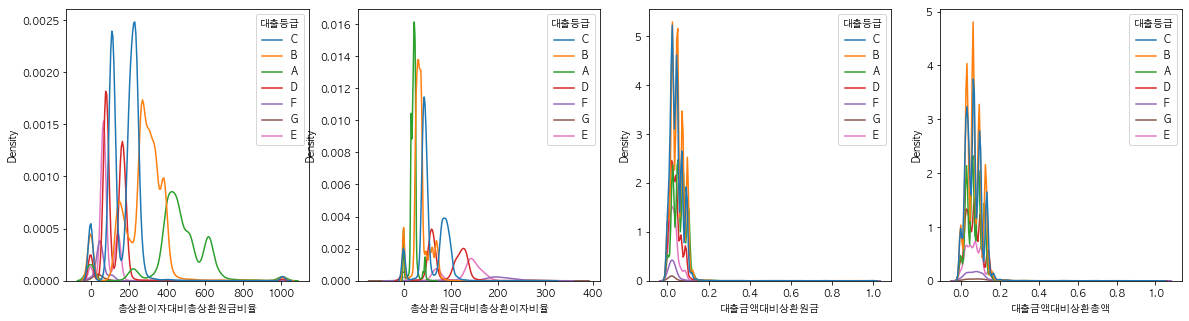

In [21]:
float_features = ["총상환이자대비총상환원금비율", "총상환원금대비총상환이자비율", "대출금액대비상환원금", "대출금액대비상환총액"]

fig, axes = plt.subplots(1, len(float_features), figsize=(20, 5), sharey=False)

for i, col in enumerate(float_features):
    sns.kdeplot(data=train, x=col, hue="대출등급", ax=axes[i])

plt.show()

로그 변환을 통해 skewness / kurtosis 감소 가능

In [22]:
non_log_trans_col = ["대출기간", "남은대출금액대비상환총액", "대출등급"]
log_trans_col = list(set(train.columns.tolist()) - set(non_log_trans_col))

In [23]:
train[log_trans_col] = np.log1p(train[log_trans_col])
test[log_trans_col] = np.log1p(test[log_trans_col])

In [24]:
label2idx = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7}

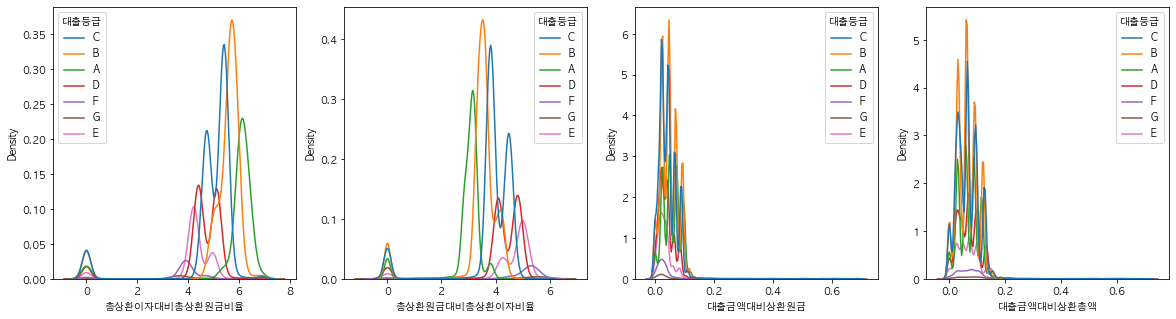

In [25]:
fig, axes = plt.subplots(1, len(float_features), figsize=(20, 5), sharey=False)

for i, col in enumerate(float_features):
    sns.kdeplot(data=train, x=col, hue="대출등급", ax=axes[i])

plt.show()

In [26]:
from xgboost import XGBClassifier

X_train = train.drop(columns="대출등급")
y_train = train["대출등급"].replace(label2idx)

X_test = test

dataset = make_fold_dataset(X_train, y_train)
trainset, validset, scaled_trainset, scaled_validset = dataset

In [29]:
def valid_kfold_with_preds(
    scaled_trainset,
    scaled_validset,
    use_features,
    params: dict,
    model,
    n_fold: int = 5,
    class_weights: bool = False,
):
    """
    - sklearn wrapper 필요
    """
    preds = []

    for fold in range(n_fold):
        X_tr, y_tr = scaled_trainset[fold]
        X_val, y_val = scaled_validset[fold]

        X_tr, X_val = X_tr[use_features], X_val[use_features]

        clf = model(**params)
        if not class_weights:
            clf.fit(X_tr, y_tr)
        else:
            weights = compute_sample_weight("balanced", y_tr)
            clf.fit(X_tr, y_tr, sample_weight=weights)

        y_pred = clf.predict(X_val)
        preds.append(y_pred)

    total_preds = np.concatenate(preds)
    total_true = np.concatenate([x[1] for x in scaled_validset])

    valid_score = f1_score(total_preds, total_true, average="macro")
    valid_score = round(np.mean(valid_score), 5)

    return valid_score, preds


In [30]:
base_params = {
    "objective": "multi:softmax",
    "gamma": 0,  # default
    "learning_rate": 0.3,  # default
    "n_estimators": 200,
    "max_depth": 6,  # default
    "reg_lambda": 1,  # default
    "eval_metric": ["merror", "mlogloss"],
    "random_state": 42,
}

In [31]:
score, preds = valid_kfold_with_preds(scaled_trainset,
            scaled_validset,
            final_features,
            base_params,
            XGBClassifier)

print(score)

0.94825


In [32]:
X_train, X_test = scale_dataset(X_train, X_test)

X_train, X_test = X_train[final_features], X_test[final_features]

model = XGBClassifier(**base_params)
model.fit(X_train, y_train)

y_preds = model.predict(X_test)

sub = submission.copy()
sub["대출등급"] = y_preds
sub["대출등급"] = sub["대출등급"].map({v: k for k, v in label2idx.items()})

sub.to_csv("../submit/final_submit.csv", index=False)